<a href="https://colab.research.google.com/github/nyleashraf/NYPD-Stop-and-Frisk/blob/master/StopAndFriskNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> New York City Stop and Frisk Program </center>
### <center> CS329E Elements of Data Analytics
#### <center> Project members: Anna Williams, Zizhuo (Xavier) Dong, Nyle Ashraf, Alexandra Smith </center>

This data is collected from [New York City Stop and Frisk Program](https://public.enigma.com/browse/tag/policing/101) dataset. It should be noted that every record in this dataset is a person that has been stopped in New York City. 


In [0]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import time
import pickle
import os

In [0]:
wd = os.getcwd()

**Import all data sets**

In [0]:
data1 = pd.read_csv(wd + '/data/NYPD_SF_2003.csv')
data2 = pd.read_csv(wd + '/data/NYPD_SF_2005.csv')
data3 = pd.read_csv(wd + '/data/NYPD_SF_2006.csv')
data4 = pd.read_csv(wd + '/data/NYPD_SF_2009.csv')
data5 = pd.read_csv(wd + '/data/NYPD_SF_2010.csv')
data6 = pd.read_csv(wd + '/data/NYPD_SF_2011.csv')
data7 = pd.read_csv(wd + '/data/NYPD_SF_2012.csv')

**Some datasets include 113 features, while others include 114 features. In order to easily merge the datasets into one dataframe, we will need to identify the common features and merge only those features.**

In [0]:
from functools import reduce
features1 = data1.columns.get_values()
features2 = data2.columns.get_values()
features3 = data3.columns.get_values()
features4 = data4.columns.get_values()
features5 = data5.columns.get_values()
features6 = data6.columns.get_values()
features7 = data7.columns.get_values()
common_features = reduce(np.intersect1d, (features1, features2, features3, features4, features5, features6, features7))
print(common_features)
print("Number of common features: ", common_features.size)

['ac_assoc' 'ac_cgdir' 'ac_evasv' 'ac_incid' 'ac_inves' 'ac_other'
 'ac_proxm' 'ac_rept' 'ac_stsnd' 'ac_time' 'addrnum' 'addrpct' 'addrtyp'
 'adtlrept' 'age' 'aptnum' 'arstmade' 'arstoffn' 'asltweap' 'beat' 'build'
 'city' 'comppct' 'compyear' 'contrabn' 'crimsusp' 'crossst' 'cs_bulge'
 'cs_casng' 'cs_cloth' 'cs_descr' 'cs_drgtr' 'cs_furtv' 'cs_lkout'
 'cs_objcs' 'cs_other' 'cs_vcrim' 'datestop' 'dob' 'explnstp' 'eyecolor'
 'frisked' 'haircolr' 'ht_feet' 'ht_inch' 'inout' 'knifcuti' 'machgun'
 'officrid' 'offshld' 'offunif' 'offverb' 'othfeatr' 'othpers' 'othrweap'
 'pct' 'perobs' 'perstop' 'pf_baton' 'pf_drwep' 'pf_grnd' 'pf_hands'
 'pf_hcuff' 'pf_other' 'pf_pepsp' 'pf_ptwep' 'pf_wall' 'pistol' 'post'
 'premname' 'premtype' 'race' 'radio' 'recstat' 'repcmd' 'rescode'
 'revcmd' 'rf_attir' 'rf_bulg' 'rf_furt' 'rf_knowl' 'rf_othsw' 'rf_rfcmp'
 'rf_vcact' 'rf_vcrim' 'rf_verbl' 'riflshot' 'sb_admis' 'sb_hdobj'
 'sb_other' 'sb_outln' 'searched' 'sector' 'ser_num' 'serialid' 'sex'
 'state' '

In [0]:
datasets = [data1, data2, data3, data4, data5, data6, data7]
for dataset in datasets:
    dataset = dataset[common_features]


**Although we have removed the non-common features from the data for each year, we are still not ready to append the individual dataframes into one larger dataframe. The ordering of columns in each dataframe needs to be consistent before we bring them together.**

In [0]:
columns = data1.columns.tolist()
for dataframe in datasets: 
    dataframe = dataframe.loc[:, columns]

In [0]:
for dataset in datasets: 
    counter = 0
    if dataset.columns[counter] != columns[counter]:
        raise Exception("Column ordering not consistent.")
    else:
        counter += 1
print("All datasets consistent with our ordering.")

All datasets consistent with our ordering.


In [0]:
dataframe = pd.concat(datasets, ignore_index = True)
dataframe = dataframe.loc[:, columns]
print("Shape of combined dataframe: ", dataframe.shape)
dataframe.head()

Shape of combined dataframe:  (3466621, 113)


,x,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm,serialid
0,10500,2003,108.0,168.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501
1,10501,2003,107.0,230.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10502
2,8341,2003,33.0,162.0,2003-01-18T00:00:00,00:02,NaN,O,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8342
3,9812,2003,70.0,189.0,2003-01-21T00:00:00,21:10,NaN,O,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9812
4,7455,2003,114.0,125.0,2003-01-16T00:00:00,15:15,NaN,O,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7455


### **Data Exploration**

During this segement, we explore the distribution of our data. We want to find: 
- Significant or notable values
- Outliers/Noise 
- NaN enumeration 

Now that we have built one dataframe with all of our data points, we can begin feature engineering by: (1) creating new, useful features from those that currently exist, and (2) removing features that are either not useful or contain excessive null values.

#### **Null values and Datatypes**

In [0]:
dataframe_expl = dataframe.copy()
dataframe.dtypes

x             int64
year          int64
pct         float64
ser_num     float64
datestop     object
             ...   
ycoord      float64
dettypcm     object
linecm      float64
detailcm    float64
serialid      int64
Length: 113, dtype: object

In [0]:
print('Total number of null values', dataframe_expl.isnull().values.sum())

Total number of null values 52772347


In [0]:
# The records that have no null values
# may not be useful
no_nas= (dataframe_expl.loc[:,dataframe_expl.isnull().sum() == 0])
print(no_nas.shape)
no_nas

(3466621, 60)


,x,year,explnstp,othpers,arstmade,sumissue,frisked,searched,contrabn,adtlrept,...,rf_knowl,ac_stsnd,ac_other,sb_hdobj,sb_outln,sb_admis,sb_other,rf_furt,rf_bulg,serialid
0,10500,2003,Y,Y,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,10501
1,10501,2003,Y,Y,Y,N,Y,N,Y,N,...,N,N,N,N,N,N,N,N,Y,10502
2,8341,2003,Y,N,N,N,Y,N,N,N,...,N,N,N,N,N,N,N,N,N,8342
3,9812,2003,Y,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,9812
4,7455,2003,Y,Y,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,7455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466616,46252,2012,Y,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,46252
3466617,46253,2012,Y,N,N,N,Y,Y,N,N,...,Y,N,N,Y,N,N,N,Y,N,46253
3466618,46254,2012,Y,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,46254
3466619,46949,2012,Y,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,46949


In [0]:
print('General information about the data frame')
dataframe_expl.info()

General information about the data frame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466621 entries, 0 to 3466620
Columns: 113 entries, x to serialid
dtypes: float64(18), int64(3), object(92)
memory usage: 2.9+ GB


In [0]:
# Dataframe of all columns with atleast one null value.
columns_with_nulls = dataframe_expl.loc[:,dataframe_expl.isnull().any()]
columns_with_nulls

,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,perstop,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,108.0,168.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,10.0,ASSAULT,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,107.0,230.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,5.0,BURGLARY,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33.0,162.0,2003-01-18T00:00:00,00:02,NaN,O,NaN,1.0,GUN RUN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70.0,189.0,2003-01-21T00:00:00,21:10,NaN,O,NaN,2.0,CSCS,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114.0,125.0,2003-01-16T00:00:00,15:15,NaN,O,NaN,1.0,ROBBERY,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466616,48.0,474.0,2012-01-22T00:00:00,119,A,O,P,1.0,ROBBERY,2.0,...,NaN,48.0,E,*,NaN,1017155.0,247299.0,CM,1.0,85.0
3466617,1.0,221.0,2012-01-22T00:00:00,119,A,O,P,1.0,GRAND LARCENY,5.0,...,NaN,1.0,I,NaN,NaN,982962.0,203381.0,CM,1.0,45.0
3466618,42.0,573.0,2012-01-22T00:00:00,120,A,O,P,30.0,GLA,5.0,...,NaN,42.0,D,NaN,NaN,NaN,NaN,CM,1.0,46.0
3466619,44.0,1351.0,2012-01-22T00:00:00,1545,A,O,P,5.0,ROBBERY,5.0,...,NaN,44.0,F,NaN,NaN,1007022.0,243322.0,CM,1.0,85.0


#### **Distribution of the data by race and build**

In [0]:
print('All possible values in race column', dataframe_expl['race'].unique())

All possible values in race column ['Q' 'W' 'B' 'P' 'A' 'Z' 'I' nan 'X' 'U']


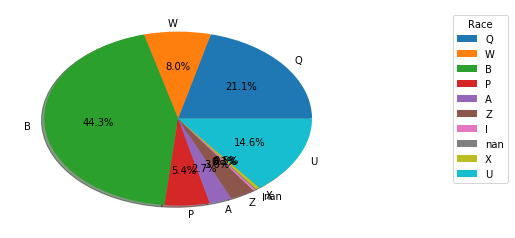

In [0]:
fig3, ax3 = plt.subplots()
labels = list(dataframe['race'].unique())
num_Q=dataframe['race'].value_counts()['Q']
num_W=dataframe['race'].value_counts()['W']
num_B=dataframe['race'].value_counts()['B']
num_P=dataframe['race'].value_counts()['P']
num_A=dataframe['race'].value_counts()['A']
num_Z=dataframe['race'].value_counts()['Z']
num_I=dataframe['race'].value_counts()['I']
num_X=dataframe['race'].value_counts()['X']
num_U=dataframe['race'].value_counts()['U']
num_na=dataframe['sex'].isna().sum()
sizes = [num_Q, num_W,num_B,num_P,num_A,num_Z,num_I,num_X,num_U,num_na]
wedges, texts, autotexts=ax3.pie(sizes, labels = labels, autopct='%1.1f%%', shadow=True)
ax3.legend(wedges, labels, title='Race', loc="upper right", bbox_to_anchor=(1,0,0.5,1))
plt.show()

#### **Distribution of records by Month**
##### **Note that this by all months between 2003-2012**

We discussed the possibility that stops in NYC may have a trend corresponding with seasonality. This analysis has led to the conclusion that the dataset is well distributed across all months.

In [0]:
values = dataframe_expl['datestop'].map(lambda x: x[5:7], na_action='ignore')
dataframe_expl.insert(5, 'month', values, allow_duplicates=True)

In [0]:
print(dataframe_expl.shape)

months = ['01', '02', '03','04', '05','06','07','08','09','10','11','12']

(3466621, 114)


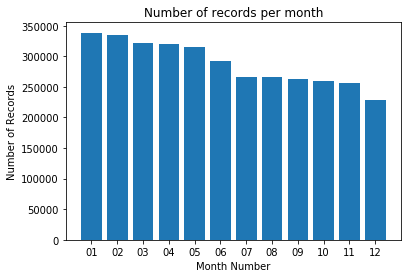

In [0]:
fig2, ax2 = plt.subplots()

plt.ylabel('Number of Records')
plt.xlabel('Month Number')
plt.title('Number of records per month')
ax2 = plt.bar(months, dataframe_expl['month'].value_counts())

#### **Distribution of the data by Frisked and Searched**

After an introduction to the data, we realize that perhaps the most important attribute from this dataset is among those that will be stopped can we predict that they will be frisked (pat down). Thus, we examine the representation of the datapoints that have been frisked and have been searched. 

What we learn from this segment is that the among the records, the frisked attribute is well distributed with respect to its categories "Y" or "N". Thus, we decide to create a classifier that will: Given that record X has Y features, will record X be frisked?  

In [0]:
frisked=dataframe['frisked'].value_counts()
searched=dataframe['searched'].value_counts()

In [0]:
# create a pir chart of percent that were frisked by race. We have divided this by the race 
# B and not B. 
race_select = dataframe.loc[dataframe['race']=='B']
race_select_c = dataframe.loc[dataframe['race']!='B']

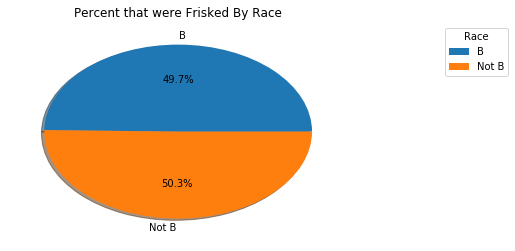

In [0]:

fig5, ax5 = plt.subplots()
labels = ['B', 'Not B']
num_frisked_B = race_select['frisked'].value_counts()[1]
num_frisked_not_B=race_select_c['frisked'].value_counts()[1]
sizes = [num_frisked_B, num_frisked_not_B]
wedges, texts, autotexts=ax5.pie(sizes, labels = labels, autopct='%1.1f%%', shadow=True)
ax5.legend(wedges, labels, title='Race', loc="upper right", bbox_to_anchor=(1,0,0.5,1))
plt.title('Percent that were Frisked By Race')
plt.show()

In [0]:
frisked

Y      1588217
N      1371913
NO      289312
YES     217179
Name: frisked, dtype: int64

In [0]:
searched

N      2707037
NO      472275
Y       253093
YES      34216
Name: searched, dtype: int64

### **Data Cleaning**

*Convert height to inches*

In [0]:
#convert height to inches
dataframe['height'] = 12 * dataframe['ht_feet'] + dataframe['ht_inch']
dataframe.drop(['ht_feet', 'ht_inch'], axis=1, inplace=True)
dataframe.head()

,x,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm,serialid,height
0,10500,2003,108.0,168.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501,68.0
1,10501,2003,107.0,230.0,2003-01-23T00:00:00,12:10,NaN,O,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10502,69.0
2,8341,2003,33.0,162.0,2003-01-18T00:00:00,00:02,NaN,O,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8342,70.0
3,9812,2003,70.0,189.0,2003-01-21T00:00:00,21:10,NaN,O,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9812,68.0
4,7455,2003,114.0,125.0,2003-01-16T00:00:00,15:15,NaN,O,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7455,70.0


*Bin date and time columns, binarize yes/no columns*

In [0]:
#Bin datestop by month and timestop by hour
dataframe['datestop'] = pd.to_datetime(dataframe['datestop'])
# date_dict = dict(zip(['01','02','03','04','05','06','07','08','09','10','11','12'],
#                 ['January','February','March','April','May','June','July','August','September','October','November','December']))
dataframe['datestop_month'] = dataframe['datestop'].dt.month
dataframe['timestop_hour'] = dataframe['timestop'].replace(np.NaN, '00')
dataframe['timestop_hour'] = dataframe['timestop_hour'].astype(str).apply(lambda x: x[0:2])
hour_dict = dict(zip(['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'],
                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23]))
dataframe['timestop_hour'] = dataframe['timestop_hour'].map(hour_dict)

#Map binary predictor features to 0 and 1
inout_dict = dict(zip(['I','O'],[1, 0]))
yesno_dict = dict(zip(['Y','YES','N','NO'],[1, 1, 0, 0]))
sex_dict = dict(zip(['F','M'],[1, 0]))

dataframe['inout'] = dataframe['inout'].map(inout_dict)
dataframe['sex'] = dataframe['sex'].map(sex_dict)

yesno_cols = ['explnstp', 'othpers', 'arstmade', 'offunif',
       'frisked', 'searched', 'contrabn', 'pistol',
       'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap',
       'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep',
       'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other',
       'ac_inves', 'rf_vcrim', 'rf_othsw', 'ac_proxm', 'rf_attir',
       'cs_objcs', 'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact',
       'cs_cloth', 'cs_drgtr', 'ac_evasv', 'ac_assoc', 'cs_furtv',
       'rf_rfcmp', 'ac_cgdir', 'rf_verbl', 'cs_vcrim', 'cs_bulge',
       'cs_other', 'ac_incid', 'ac_time', 'rf_knowl', 'ac_stsnd',
       'ac_other', 'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other',
       'rf_furt', 'rf_bulg']

for x in yesno_cols:
    dataframe[x] = dataframe[x].map(yesno_dict)

dataframe.head()

,x,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,post,xcoord,ycoord,dettypcm,linecm,detailcm,serialid,height,datestop_month,timestop_hour
0,10500,2003,108.0,168.0,2003-01-23,12:10,NaN,0.0,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10501,68.0,1.0,12.0
1,10501,2003,107.0,230.0,2003-01-23,12:10,NaN,0.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10502,69.0,1.0,12.0
2,8341,2003,33.0,162.0,2003-01-18,00:02,NaN,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8342,70.0,1.0,0.0
3,9812,2003,70.0,189.0,2003-01-21,21:10,NaN,0.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9812,68.0,1.0,21.0
4,7455,2003,114.0,125.0,2003-01-16,15:15,NaN,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7455,70.0,1.0,15.0


*Select columns needed for model*

In [0]:
#select only relevant columns needed for model
rel_cols = ['year', 'pct',
       'inout', 'perobs', 'perstop', 'typeofid',
       'explnstp', 'othpers', 'arstmade', 'offunif',
       'frisked', 'searched', 'contrabn', 'pistol',
       'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap',
       'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep',
       'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other',
       'ac_inves', 'rf_vcrim', 'rf_othsw', 'ac_proxm', 'rf_attir',
       'cs_objcs', 'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact',
       'cs_cloth', 'cs_drgtr', 'ac_evasv', 'ac_assoc', 'cs_furtv',
       'rf_rfcmp', 'ac_cgdir', 'rf_verbl', 'cs_vcrim', 'cs_bulge',
       'cs_other', 'ac_incid', 'ac_time', 'rf_knowl', 'ac_stsnd',
       'ac_other', 'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other',
       'rf_furt', 'rf_bulg',
       'sex', 'race', 'age', 'weight', 'build', 'height','datestop_month','timestop_hour']
dataframe_rel = dataframe[rel_cols]

*List-wise deletion of records*

In [0]:
dataframe_rel.dropna(how='any',inplace = True)
dataframe_rel.drop(dataframe_rel[dataframe_rel['pct'] == 999].index,inplace=True)
dataframe_rel.drop(dataframe_rel[dataframe_rel['age'] == 999].index,inplace=True)
dataframe_rel.drop(dataframe_rel[dataframe_rel['weight'] == 999].index,inplace=True)
dataframe_rel.drop(dataframe_rel[dataframe_rel['height'] == 999].index,inplace=True)

*One hot encode categorical data*

In [0]:
df = dataframe_rel.sample(n = 100000, random_state = 42)

In [0]:
cat_cols = ['typeofid','race','build']
df = pd.concat([df, pd.get_dummies(df[cat_cols], prefix=cat_cols)], axis=1)
df.drop(cat_cols, axis=1, inplace = True)
df = df.astype('int32')
df.head()

,year,pct,inout,perobs,perstop,explnstp,othpers,arstmade,offunif,frisked,...,race_Q,race_U,race_W,race_X,race_Z,build_H,build_M,build_T,build_U,build_Z
1692635,2010,40,1,7,2,1,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
2111634,2010,41,0,2,3,1,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1704518,2010,75,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1985883,2010,46,0,2,10,1,1,0,1,1,...,1,0,0,0,0,0,1,0,0,0
2080217,2010,103,0,2,5,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## **Build Decision Tree Classifier**

In [0]:
c = 'frisked'
# c = 'searched'
label_df = df[c]
feature_df = df.drop(['frisked','searched'], axis = 1)
num_cols = ['year','pct','perobs','perstop','age','weight','height','datestop_month','timestop_hour']
scaler = MinMaxScaler()
feature_df[num_cols] = scaler.fit_transform(feature_df[num_cols])

Average 10 fold cross validation score = 0.987
Area Under Curve:  0.9871349583140081
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45879
           1       0.99      0.99      0.99     54121

    accuracy                           0.99    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000



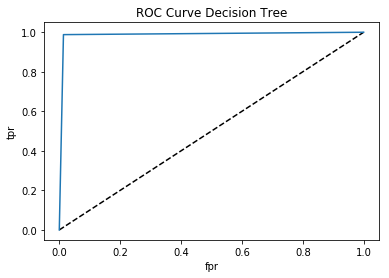

In [0]:
def run_dt_classifier(feature_df,label_df, test_size, roc_curve_gen = False):
    f_train, f_test, l_train, l_test = train_test_split(feature_df,label_df, test_size=test_size)
    clf = DecisionTreeClassifier(criterion = 'gini')
    clf_fit= clf.fit(f_train,l_train)
    #Predicting frisked
    # print("Frisked:")
    label_predicted = clf_fit.predict(f_test)
    acc = accuracy_score(l_test, label_predicted)
    # print("Decision Tree classifier accuracy on initial test data = {}".format(round(acc,3)))
    # print("")

    cm = confusion_matrix(l_test,label_predicted,labels=[0,1])
    # print("Confusion Matrix = \n{}".format(cm))

    # print("")
    cv_score = cross_val_score(clf_fit,feature_df,y=label_df,cv=10)
    cv_predict=cross_val_predict(clf_fit, feature_df, label_df, cv=10)

    print("Average 10 fold cross validation score = {}".format(round(np.mean(cv_score),3)))
    if roc_curve_gen:
        predict_prob = clf_fit.predict_proba(f_test)
        fpr, tpr, thresholds = roc_curve(l_test, predict_prob[:,1])
        print('Area Under Curve: ', roc_auc_score(l_test, predict_prob[:,1]))
        print(classification_report(label_df, cv_predict))

        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label='Decision Tree')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC Curve Decision Tree')
        plt.show()
    return cv_score,clf_fit
dt_acc,clf_fit = run_dt_classifier(feature_df,label_df, 0.20, True)

## **Build Random Forest Classifier (Ensemble)**

Average 10 fold cross validation score = 0.991
Area Under Curve:  0.9986724437326708
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     45879
           1       0.99      0.99      0.99     54121

    accuracy                           0.99    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000



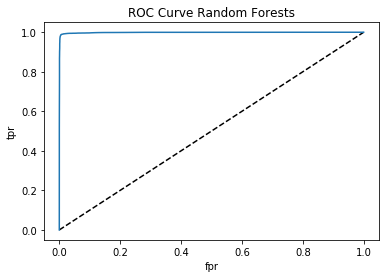

In [0]:
def run_rf_classifier(feature_df,label_df, test_size, roc_curve_gen=False):
    f_train, f_test, l_train, l_test = train_test_split(feature_df,label_df, test_size=0.20)
    forest = RandomForestClassifier(n_estimators=100)
    forest_fit= forest.fit(f_train,l_train)
    #Predicting frisked
    # print("Frisked:")
    label_predicted = forest_fit.predict(f_test)
    acc = accuracy_score(l_test, label_predicted)
    # print("Random Forest classifier accuracy on initial test data = {}".format(round(acc,3)))
    # print("")

    cm = confusion_matrix(l_test,label_predicted,labels=[0,1])
    # print("Confusion Matrix = \n{}".format(cm))

    # print("")
    cv_score = cross_val_score(forest_fit,feature_df,y=label_df,cv=10)
    cv_predict=cross_val_predict(forest_fit, feature_df, label_df, cv=10)
    

    print("Average 10 fold cross validation score = {}".format(round(np.mean(cv_score),3)))
    if roc_curve_gen:
        
        predict_prob = forest_fit.predict_proba(f_test)
        fpr, tpr, thresholds = roc_curve(l_test, predict_prob[:,1])
        print('Area Under Curve: ', roc_auc_score(l_test, predict_prob[:,1]))
        print(classification_report(label_df, cv_predict))

        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label='Random Forests')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC Curve Random Forests')
        plt.show()
    return cv_score,forest_fit
rf_acc,forest_fit = run_rf_classifier(feature_df,label_df, 0.20, True)

<p>At this point, we notice that our ROC curve and accuracy is suspiciously perfect for both classifiers. This implies that there is are features that highly correlated with the label 'Frisked'. The result from a high correlation is a tree that is all too perfect at predicting whether a new record will be frisked or not. Thus, we launch an analysis to determine which features are highly correlated with the 'frisked' label. We also revisit each label individually to determine which labels will intuitively need to be removed.</p>

## **Ranking Features Using Two-Way Table**

<p>For each feature, we computer the possible combinations of outputs with the 'frisked' label. Thus, for each feature there are four possibile combinations. Here, we are computing a measure of imbalence by taking a ratio of those that are positive for containing a characteristic and those that have been frisked. Please refer to the report for more information and for motivation.</p>

In [0]:
perc = dict()
for col in yesno_cols:
    # Ign the frisked column. 
    if col == 'frisked':
        continue
    gpby = dataframe.groupby([col, 'frisked'])
    perc[col] = gpby.size()[1,1]/(gpby.size()[1,0]+ gpby.size()[1,1])

## **Visualizing Accuracy vs Number of Features Used**

In [0]:
data = np.asarray(list(perc.items()))
imbalance_df = pd.DataFrame(data = data, columns = ['feature','imbalance'])
imbalance_df.sort_values(['imbalance'],ascending=False,inplace=True)
imbalance_df.head()

,feature,imbalance
25,rf_attir,0.9980322881792428
22,rf_vcrim,0.9973123837089105
51,rf_furt,0.9972002089973002
36,rf_rfcmp,0.9971623426173216
52,rf_bulg,0.9968168129502064


In [0]:
acc_list = []
feature_removed = []
feature_list = [e for e in rel_cols if e not in ('typeofid','frisked', 'race', 'build','searched')]
i=0
for feature in imbalance_df['feature'].values:
    print("Removed {} Features:".format(i))
    dt_acc,clf_fit = run_dt_classifier(feature_df[feature_list],label_df, 0.20, False)
    acc_list.append(np.mean(dt_acc))
    feature_removed.append(i)
    if feature in feature_list:
        feature_list.remove(feature)
    i+=1
    if i>15:
        break

Removed 0 Features:
Average 10 fold cross validation score = 0.987
Removed 1 Features:
Average 10 fold cross validation score = 0.953
Removed 2 Features:
Average 10 fold cross validation score = 0.91
Removed 3 Features:
Average 10 fold cross validation score = 0.768
Removed 4 Features:
Average 10 fold cross validation score = 0.744
Removed 5 Features:
Average 10 fold cross validation score = 0.726
Removed 6 Features:
Average 10 fold cross validation score = 0.726
Removed 7 Features:
Average 10 fold cross validation score = 0.723
Removed 8 Features:
Average 10 fold cross validation score = 0.715
Removed 9 Features:
Average 10 fold cross validation score = 0.715
Removed 10 Features:
Average 10 fold cross validation score = 0.716
Removed 11 Features:
Average 10 fold cross validation score = 0.715
Removed 12 Features:
Average 10 fold cross validation score = 0.716
Removed 13 Features:
Average 10 fold cross validation score = 0.715
Removed 14 Features:
Average 10 fold cross validation score

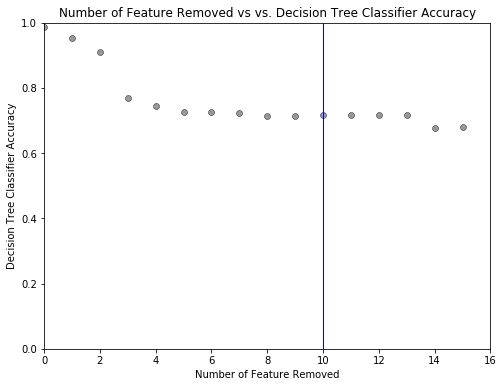

In [0]:
plt.figure(figsize=(8,6))
plt.arrow(10,0,0,1,width=0.02,color='blue',head_length=0.0,head_width=0.0)
plt.scatter(feature_removed,acc_list,s=None, c="grey", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.5, verts=None, edgecolors="black")
plt.title('Number of Feature Removed vs vs. Decision Tree Classifier Accuracy')
plt.xlabel('Number of Feature Removed')
plt.ylabel('Decision Tree Classifier Accuracy')
plt.xlim(0,i); plt.ylim(0,1)
plt.show() 

#### Remove features that have been found to be too highly correlated with our chosen label. We also base this on intuition.

In [0]:
#Drop columns discovered to have high imbalance from two way table analysis and based on intuition
rf = ['rf_furt', 'rf_vcrim', 'rf_rfcmp', 'rf_bulg', 'rf_attir', 'rf_vcact', 'rf_knowl', 'rf_verbl', 'rf_othsw']
sb = ['sb_hdobj', 'sb_other', 'sb_outln', 'sb_admis']
pf = ['pf_hcuff', 'pf_hands', 'pf_wall', 'pf_grnd', 'pf_ptwep', 'pf_drwep', 'pf_baton', 'pf_other', 'pf_pepsp']
found = ['contrabn', 'knifcuti', 'othrweap', 'pistol', 'asltweap', 'riflshot', 'machgun']
feature_df.drop(rf, axis=1, inplace=True)
feature_df.drop(sb, axis=1, inplace=True)
feature_df.drop(pf, axis=1, inplace=True)
feature_df.drop(found, axis=1, inplace=True)
new_feature_df = feature_df.copy(deep=True)
new_feature_df.head()

,year,pct,inout,perobs,perstop,explnstp,othpers,arstmade,offunif,ac_inves,...,race_Q,race_U,race_W,race_X,race_Z,build_H,build_M,build_T,build_U,build_Z
1692635,0.777778,0.319672,1,0.035957,0.002002,1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2111634,0.777778,0.327869,0,0.031098,0.003003,1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1704518,0.777778,0.606557,0,0.030126,0.001001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1985883,0.777778,0.368852,0,0.031098,0.010010,1,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2080217,0.777778,0.836066,0,0.031098,0.005005,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Average 10 fold cross validation score = 0.641
Area Under Curve:  0.6421228412731573


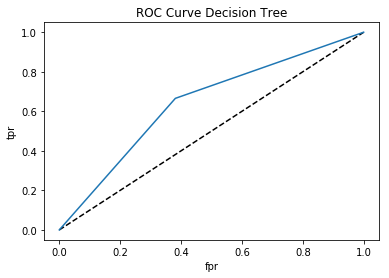

In [0]:
dt_acc,clf_fit = run_dt_classifier(new_feature_df,label_df, 0.20, True)

We find the first precision, recall and accuracy of our Decision Tree. This is prior to tuning!

In [0]:
cv_predict=cross_val_predict(clf_fit, new_feature_df, label_df, cv=10)
print(classification_report(label_df, cv_predict))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61     45879
           1       0.67      0.67      0.67     54121

    accuracy                           0.64    100000
   macro avg       0.64      0.64      0.64    100000
weighted avg       0.64      0.64      0.64    100000



## **Decision Tree Classifier**

In [0]:
md_range=list(np.linspace(2, 10, num=5, endpoint=True,dtype = int))
msl_range=list(np.linspace(1, 3, num=3, endpoint=True,dtype = int))
mf_range=list(np.linspace(2, 10, num=5, endpoint=True,dtype = int))

f_train, f_test, l_train, l_test = train_test_split(feature_df,label_df, test_size=.2)
clf = DecisionTreeClassifier(criterion = 'gini')
clf_fit= clf.fit(f_train,l_train)

parameters = {'max_depth': md_range, 'min_samples_leaf': msl_range, 'max_features':mf_range}

GSCV = GridSearchCV(estimator=clf_fit,param_grid=parameters,cv=5,scoring = 'accuracy',iid=True)
GSCV_fit = GSCV.fit(f_train,l_train)
print("Best parameters value for accuracy = {}".format(GSCV_fit.best_params_))

clf = DecisionTreeClassifier(max_depth=GSCV_fit.best_params_['max_depth'], min_samples_leaf=GSCV_fit.best_params_['min_samples_leaf'],
                            max_features=GSCV_fit.best_params_['max_features'])
print("Overall Average Accuracy: {}".format(round(cross_val_score(clf, feature_df, label_df, cv=10).mean(),3)))
#GSCV_predict_result = GSCV_fit.predict(f_test)
cv_predict=cross_val_predict(clf, feature_df, label_df, cv=10)
#acc = accuracy_score(l_test,GSCV_predict_result)

#print("Decision Tree classifier with best parameter value, accuracy = {}".format(round(acc,3)))

cm = confusion_matrix(label_df,cv_predict,labels=[0,1])

print("Confusion Matrix = \n{}".format(cm))
print(classification_report(label_df, cv_predict))

Best parameters value for accuracy = {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1}
Overall Average Accuracy: 0.681
Confusion Matrix = 
[[29267 16612]
 [15062 39059]]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     45879
           1       0.70      0.72      0.71     54121

    accuracy                           0.68    100000
   macro avg       0.68      0.68      0.68    100000
weighted avg       0.68      0.68      0.68    100000



From the cell below, we report that a Decision Tree Classifier would obtain accuracy: 0.684, precision: 0.68, and recall: 0.67. An improvement from our first trial of Decision Trees!

In [0]:
cv_score = cross_val_score(GSCV_fit,new_feature_df,y=label_df,cv=5)
print("Decision Tree classifier with nested cross validation, accuracy = {}".format(round(np.mean(cv_score),3)))

label_pred_nested = cross_val_predict(GSCV_fit, new_feature_df, label_df, cv=5)
print(classification_report(label_df, label_pred_nested))

Decision Tree classifier with nested cross validation, accuracy = 0.684
              precision    recall  f1-score   support

           0       0.67      0.60      0.63     45879
           1       0.69      0.74      0.72     54121

    accuracy                           0.68    100000
   macro avg       0.68      0.67      0.68    100000
weighted avg       0.68      0.68      0.68    100000



## **Naive Bayes Classifier**

Based on the following we report that a Naive Bayes classifier would have accuracy: .683, precision: .68, recall:.68

In [0]:
nb = GaussianNB()
scores = cross_val_score(nb, feature_df, label_df, cv=10)
print("Scores: {}".format(np.round(scores, 3)))
print("Mean Accuracy for Naive Bayes, 10-fold cross validation: {}".format(np.round(np.mean(scores), 3)))

predict_labels = cross_val_predict(nb, feature_df, label_df, cv=10)
cm = confusion_matrix(label_df, predict_labels)
print('Confusion matrix: ')
print(cm)
print(classification_report(label_df, predict_labels))

Scores: [0.683 0.677 0.684 0.682 0.689 0.683 0.679 0.676 0.686 0.692]
Mean Accuracy for Naive Bayes, 10-fold cross validation: 0.683
Confusion matrix: 
[[31982 13897]
 [17797 36324]]
              precision    recall  f1-score   support

           0       0.64      0.70      0.67     45879
           1       0.72      0.67      0.70     54121

    accuracy                           0.68    100000
   macro avg       0.68      0.68      0.68    100000
weighted avg       0.69      0.68      0.68    100000



AUC:  0.736986326105897


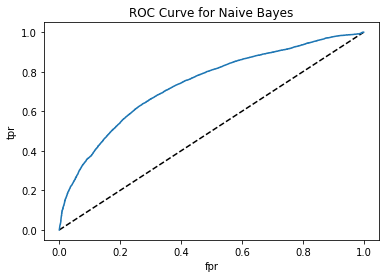

In [0]:
f_train, f_test, l_train, l_test = train_test_split(feature_df,label_df, test_size=.2)
nb = nb.fit(f_train, l_train)
predict_prob=nb.predict_proba(f_test)

fpr, tpr, thresholds= roc_curve(l_test, predict_prob[:,1])

print('AUC: ', roc_auc_score(l_test, predict_prob[:,1]))

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Naive Bayes')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Naive Bayes')
plt.show()